# 通过 PyTorch 构建神经网络

下面我们将了解如何使用 PyTorch 构建神经网络。

In [1]:
# 导入各库

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

首先，我们需要获取数据集。这些数据位于 `torchvision` 软件包中。以下代码将下载 MNIST 数据集，然后为我们创建训练数据集和测试数据集。暂时不用对细节部分太关心，稍后你会详细学习的。

In [2]:
# 定义一组数据集的转换
'''
transforms.ToTensor() 将数据集转换成张量
transforms.Normalize() 将数据集正则化 
    前面那(0.5, 0.5, 0.5)部分的作用是将图像的RGB三通道都减去0.5
    后面那(0.5, 0.5, 0.5)部分的作用是将图像的RGB三通道的数值都除以0.5
    因为原始的图像是灰阶图每个像素的RGB都在0-1的范围 
    然后都减去0.5就可以变成-0.5-0.5范围
    然后再除以0.5 这样可以使得这一组数据的方差范围扩展至-1到1
    这样做的目的是为了使神经网络更容易学习
'''
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data 方如trainset
'''
download参数表示如果磁盘上没用 就下载
batch_size参数是批次大小 这里设定为64 即每次将会从数据集取出64张图片 
'''
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Processing...
Done!


In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

我们将训练数据加载到了 `trainloader` 中，并使用 `iter(trainloader)`使其变成迭代器。我们将用它循环访问数据集以进行训练，但是现在我只获取了第一批数据，以便查看数据。从下方可以看出，`images` 是一个大小为 (64, 1, 28, 28) 的张量。因此，每批有 64 个图像、1 个颜色通道，共有 28x28 个图像。

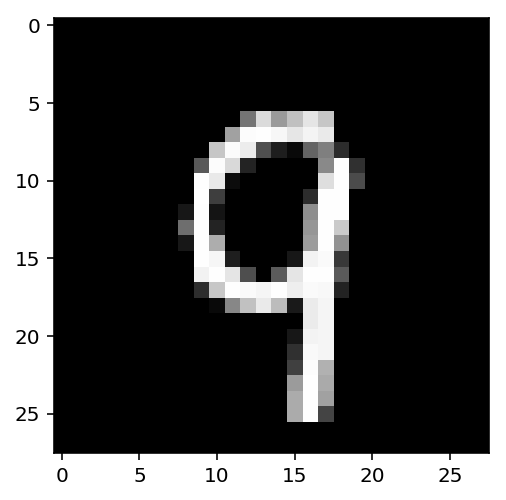

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r')

## 通过 PyTorch 构建神经网络

我将使用 PyTorch 构建一个简单的前馈网络，用于对 MNIST 图像进行分类。即该网络将接收数字图像作为输入，并预测图像中的数字。

<img src="assets/mlp_mnist.png" width=600px>

要通过 PyTorch 构建神经网络，你需要使用 `torch.nn` 模块。网络本身是继承自 `torch.nn.Module` 的类。你需要单独定义每个运算，例如针对具有 784 个输入和 128 个单元的全连接层定义为 `nn.Linear(784, 128)`。

该类需要包含对网络实现前向传递的 `forward` 方法。在此方法中，你将对之前定义的每个运算传递输入张量 `x`。`torch.nn` 模块在 `torch.nn.functional` 中还具有一些对等的功能，例如 ReLU。此模块通常导入为 `F`。要对某个层（只是一个张量）使用 ReLU 激活函数，你需要使用 `F.relu(x)`。以下是一些常见的不同激活函数。

<img src="assets/activation.png" width=700px>

对于此网络，我将添加三个全连接层，然后添加一个预测类别的 softmax 输出。softmax 函数和 S 型函数相似，都会将输入调整到 0 到 1 之间，但是还会标准化这些输入，以便所有值的和为 1，就像正常的概率分布一样。

In [6]:
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [7]:
class Network(nn.Module):
    def __init__(self):
        # Network类初始化 这里Network类是nn.Module的子类
        # super()可以调用这个子类所继承的那个类的函数或属性
        # 这里即意味着 调用了Network类的基类nn.Module类中的__init__()方法
        super().__init__()
        
        # 神经网络的架构构建
        # 定义各层, 128, 64, 10 units each fc表示全连接 线性的 
        self.fc1 = nn.Linear(784, 128) # 输入层-隐藏层1 728表示输入 128表示输出
        self.fc2 = nn.Linear(128, 64) # 隐藏层1-隐藏层2 128表示输入 64表示输出
        self.fc3 = nn.Linear(64, 10) # 隐藏层2-输出层 64输入 10个输出
        
    def forward(self, x):
        ''' 
        参数：x是一个Tensor
        我们这里所作的即是将x传入各层 然后正向计算并输出
        '''
        x = self.fc1(x) # 输入层输入x 得到隐藏层1的输出
        x = F.relu(x) # 经过激励函数RelU
        x = self.fc2(x) # 传入隐藏层1的x 得到隐藏层2的输出
        x = F.relu(x) # 经过激励函数ReLU
        x = self.fc3(x) # 传入隐藏层2的x 得到输出层输出
        # 这里不要按照视频中的填写x = F.softmax(x, dim=1) 
        # 经过softmax函数激励 dim=1是维度的意思
        # 因为这里的jupyter notebook增加了一个predict函数 负责将最后层输出的结果经过
        # softmax函数！！！
        return x
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits)

# 创建一个net对象
net = Network()
net

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### 初始化权重和偏差

权重等参数是系统自动初始化的，但是你也可以自定义如何初始化这些权重。权重和偏差是附加到你所定义的层的张量，你可以通过 `net.fc1.weight` 获取它们。

In [8]:
print(net.fc1.weight)
print(net.fc1.bias)

Parameter containing:
tensor([[-5.3677e-03, -3.2127e-02,  6.7439e-03,  ..., -1.2093e-02,
          3.4714e-02,  4.9237e-03],
        [ 2.2586e-02,  1.4596e-02,  2.6984e-02,  ..., -2.3542e-02,
          8.2146e-03, -1.1699e-02],
        [-1.7370e-02, -1.6336e-02, -2.7270e-02,  ..., -2.4807e-02,
          1.4854e-02, -1.4156e-02],
        ...,
        [-3.4931e-02,  2.4463e-02,  3.3973e-02,  ...,  2.3364e-02,
         -6.0608e-03,  1.1489e-02],
        [-1.3349e-02,  3.5432e-02, -2.7138e-02,  ..., -7.1842e-03,
          7.7524e-03,  1.3238e-02],
        [ 1.1222e-02,  9.1565e-03, -3.4951e-02,  ...,  5.1660e-04,
          6.9033e-03, -1.3992e-02]])
Parameter containing:
tensor(1.00000e-02 *
       [-1.5324, -2.6218, -3.3779, -2.5950, -1.0897,  0.8472, -0.9548,
         1.2911, -1.8510, -2.6087, -2.4057, -0.6882,  0.0471,  3.0412,
         2.1581, -1.8664,  0.2430,  0.7301,  1.4518,  1.3499,  2.7421,
         0.3554,  1.3167, -1.2868, -0.3564,  3.0366,  0.7462, -2.1502,
        -3.0168, -1

要自定义初始化过程，请原地修改这些张量。实际上存在 autograd *变量*，因此我们需要通过 `net.fc1.weight.data` 获取真正的张量。获得张量后，可以用 0（针对偏差）或随机正常值填充这些张量。

In [11]:
# 将偏置都设置为0
net.fc1.bias.data.fill_(0)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [12]:
# 设置权重 让其符合正态分布 即标准差为0.01
net.fc1.weight.data.normal_(std=0.01)

tensor([[ 3.4037e-03,  3.5347e-04,  1.3006e-02,  ..., -2.6230e-02,
          1.1115e-02,  7.0861e-03],
        [-4.7708e-03,  4.2318e-03, -8.0319e-03,  ...,  1.5013e-02,
          1.9782e-03,  6.3582e-03],
        [ 1.2053e-02,  1.3871e-03,  1.1216e-02,  ...,  1.3461e-02,
         -2.5308e-02,  1.3185e-02],
        ...,
        [ 3.2583e-03, -1.8014e-02,  1.1558e-02,  ..., -8.5922e-03,
          3.2640e-03, -1.9846e-02],
        [-1.5140e-03,  7.3642e-03, -1.0416e-02,  ...,  6.0739e-03,
         -1.0797e-02, -3.0002e-03],
        [ 5.0524e-03, -3.7222e-03,  9.0477e-03,  ..., -1.2626e-02,
          8.6455e-03,  3.4583e-03]])

### 前向传递

我们已经创建好网络，看看传入图像后会发生什么。这一过程称之为前向传递。我们将图像数据转换为张量，然后传递给网络架构定义的运算。

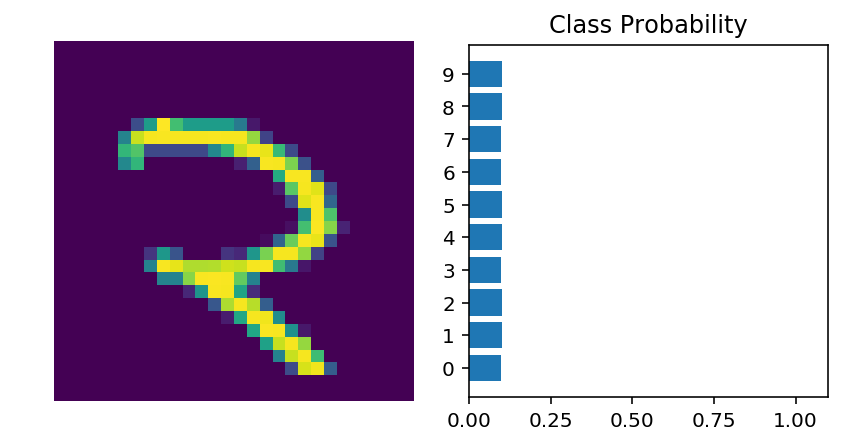

In [16]:
# 获取一些图像
dataiter = iter(trainloader)
images, labels = dataiter.next()
# 调整图像大小 64是批次 1是1维 784是向量规模 这里输入的是28*28的向量
images.resize_(64, 1, 784)

# Need to wrap it in a Variable, will explain in next notebook
inputs = Variable(images) 

# Forward pass through the network
img_idx = 0
logits = net.forward(inputs[img_idx,:])

# Predict the class from the network output
ps = F.softmax(logits, dim=1)

img = images[img_idx]
helper.view_classify(img.resize_(1, 28, 28), ps)

从上图中可以看出，我们的网络基本上根本不知道这个数字是什么，因为我们还没训练它，所有权重都是随机的！接下来，我们将了解如何训练该网络，使其能学习如何正确地对这些数字进行分类。

In [18]:
# 使用nn.Sequential来创建神经网络
# 设计超参数
input_size = 784 # 输入层
hidden_size = [128, 64] # 两个隐藏层
output_size = 10 # 输出层

# 创建神经网络
model = nn.Sequential(nn.Linear(input_size, hidden_size[0]),
                     nn.ReLU(),
                     nn.Linear(hidden_size[0], hidden_size[1]),
                     nn.ReLU(),
                     nn.Linear(hidden_size[1], output_size),
                     nn.Softmax(dim=1))

# 打印神经网络
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)
